# Heating degree days

*Heating degree days* (HDD) provide a simple measure of energy use. The assumption is that people start heating their homes once temperatures drop below a certain threshold. By counting the number of such days one can anticipate energy use.

This notebook calculates heating degree days from the GFS forecast for a number of different threshold values. Note that we use layer `49173` which contains daily aggregates of the GFS forecast. Consult the data explorer (https://ibmpairs.mybluemix.net/data-explorer) for more details on this dataset.

In [2]:
from datetime import datetime, timedelta
import re, os, pandas as pd, numpy as np, logging
from matplotlib import pyplot as plt
from scipy import ndimage
from ibmpairs import paw, authentication

We set some auxiliary variables and configure the logging system. E.g. `iso8601` helps when converting datetime objects to strings in ISO 8601-compliant format.

In [3]:
oneSec = timedelta(seconds=1)
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level=logging.WARNING)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.ERROR)

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [4]:
pairs_api_key = '<YOUR-PAIRS-API-KEY>'

Specifically, we use `authentication.OAuth2` to retrieve the access token:

In [5]:
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)
pairs_auth_headers={
    'authorization' : f'Bearer {pairs_credentials.jwt_token}',
    'content-type' : 'application/json'
}

The token will expire after an hour. This notebook will run in less time, so this is no issue. For longer running jobs use `pairs_credentials.refresh_auth_token()` to refresh. See https://pairs.res.ibm.com/tutorial/tutorials/api/paw.html#refreshing-a-token for details.


## Step 1: Run a point query

When working with PAIRS, it is generally good practice to start with a point query. Point queries are fast and create immediate responses, allowing users to ensure that they understand the data they are accessing. In this case we are interested in layer `49173`, which contains daily aggregates of the GFS temperature forecast. The layer has two dimensions, *issuetime* and *horizon*. *horizon* gives the forecast horizon in days, i.e. the time difference between the day the forecast was made and the one it is for, with the convention (for *this dataset only*) that the first day in the forecast has a horizon of 1 instead of 0. The GFS is issued several times a day, we use the 0:00 UTC forecast.

(Note that the convention for this dataset are somewhat different from the way most weather forecasts are stored in PAIRS.)

As mentioned before, consult the data explorer (https://ibmpairs.mybluemix.net/data-explorer) for details.

In [6]:
pointQueryJson = {
    'layers' : [
        {
            'type' : 'raster', 'id' : '49173',
            'dimensions' : [{'name' : 'issuetime', 'value' : '0'}, {'name' : 'horizon', 'value' : '16'}]
        }
    ],
    'spatial' : {'type' : 'point', 'coordinates' : ['40', '-100']},
    'temporal' : {'intervals' : [{
        'start' : datetime(2019, 10, 1).strftime(iso8601),
        'end' : datetime(2019, 12, 1).strftime(iso8601)
    }]}
}

In [7]:
pointQuery = paw.PAIRSQuery(pointQueryJson, auth=pairs_credentials, authType='api-key')
pointQuery.submit()
pointQuery.vdf.head()

,layerId,timestamp,longitude,latitude,value,region,property,geometry
0,49173,2019-10-02 00:00:00+00:00,-100.0,40.0,26.284510,NaN,issuetime:0;horizon:16,POINT (-100.00000 40.00000)
1,49173,2019-10-03 00:00:00+00:00,-100.0,40.0,26.139605,NaN,issuetime:0;horizon:16,POINT (-100.00000 40.00000)
2,49173,2019-10-04 00:00:00+00:00,-100.0,40.0,25.398684,NaN,issuetime:0;horizon:16,POINT (-100.00000 40.00000)
3,49173,2019-10-05 00:00:00+00:00,-100.0,40.0,13.588403,NaN,issuetime:0;horizon:16,POINT (-100.00000 40.00000)
4,49173,2019-10-06 00:00:00+00:00,-100.0,40.0,32.768459,NaN,issuetime:0;horizon:16,POINT (-100.00000 40.00000)


## Step 2: Calculating HDDs on the fly

In what follows we calculate heating degree days for the next two weeks using a user defined function (UDF). Here we will implement a simple logic that allows us to find the adjust the threshold value used dynamically. See the tutorials and documentation at https://pairs.res.ibm.com/tutorial for further details on these.

Since we want to calculate the HDDs for the next two weeks, we need yesterday's date.

In [8]:
utcToday = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=1)

The following functino generates a suitable query JSON to be submitted to PAIRS. Note that it is generally advisable to write functions that write UDF strings instead of writing them by hand.

In [9]:
def getQueryJson(today, thresholds = [18]):
    queryJson = {
        'layers' : [
            {
                'alias' : 'L{0}DA{1}'.format(lID, str(daysAhead).zfill(2)),
                'aggregation' : 'Mean',
                'type' : 'raster', 'id' : lID,
                'dimensions' : [{'name' : 'issuetime', 'value' : '0'}, {'name' : 'horizon', 'value' : str(daysAhead + 1)}],
                'temporal' : {'intervals' : [{
                    'start' : (today + timedelta(days = daysAhead)).strftime(iso8601),
                    'end' : (today + timedelta(days = daysAhead)).strftime(iso8601)
                }]},
                'output' : False
            }
        for daysAhead in range(0, 16) for lID in ['49173', '49174']],
        'spatial' : {'type' : 'poly',  'aoi' : 24},
        'temporal' : {'intervals' : [{'snapshot' : today.strftime(iso8601)}]},
        #'publish' : False
    }
    
    queryJson['layers'].extend([{
        'alias' : 'hdd{0}C'.format(t),
        'expression' : '+'.join([
            '(($L49173DA{0} + $L49174DA{0}) / 2 < {1} ? 1 : 0)'.format(str(daysAhead).zfill(2), format(t))
            for daysAhead in range(0, 16)
        ])
    } for t in thresholds])
    return queryJson

In [10]:
queryJson = getQueryJson(utcToday, thresholds = [0, 5, 10, 15])

In [11]:
query = paw.PAIRSQuery(queryJson, auth=pairs_credentials, authType='api-key')
query.submit()

In [12]:
query.poll_till_finished()
query.download()
query.create_layers()

## Step 3: Results

The following shows a spatial distribution of heating degree days for the next two weeks depending on different threshold temperatures.

In [13]:
bBox = query.metadata['Expression-hdd5C[hdd5C]-Exp']['details']['boundingBox']
extent = [bBox['minLongitude'], bBox['maxLongitude'], bBox['minLatitude'], bBox['maxLatitude']]

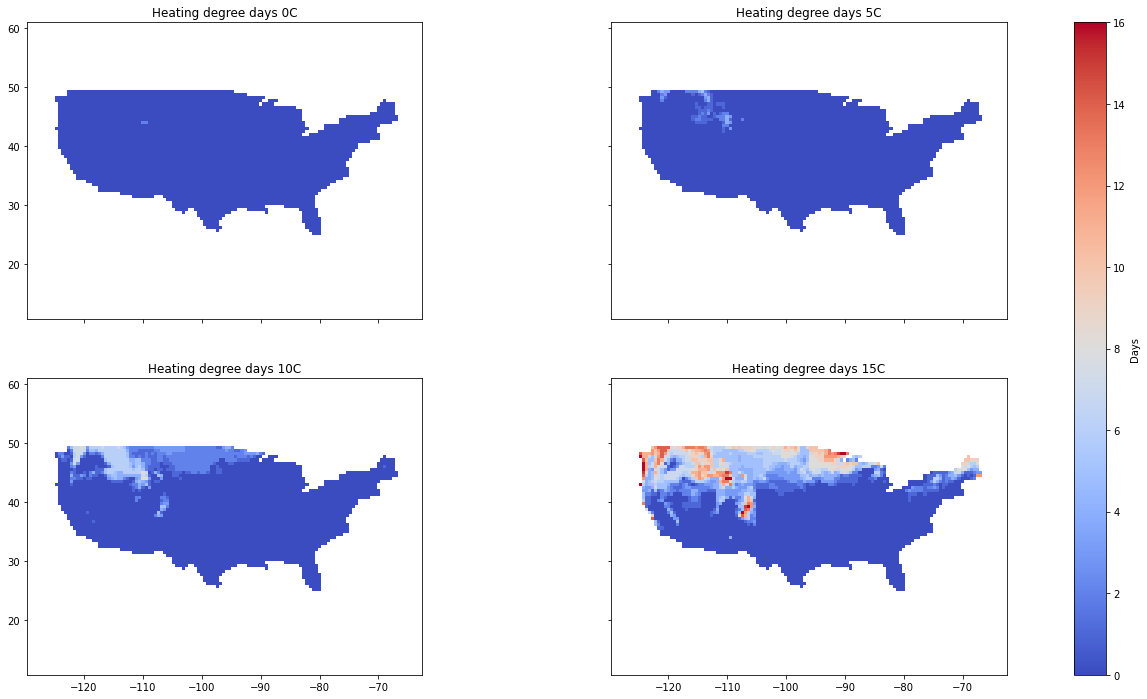

In [15]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (24, 12))
axesImage = axes[0, 0].imshow(query.data['Expression-hdd0C[hdd0C]-Exp'], cmap = 'coolwarm', vmin = 0, vmax = 16, extent = extent)
axes[0, 1].imshow(query.data['Expression-hdd5C[hdd5C]-Exp'], cmap = 'coolwarm', vmin = 0, vmax = 16, extent = extent)
axes[1, 0].imshow(query.data['Expression-hdd10C[hdd10C]-Exp'], cmap = 'coolwarm', vmin = 0, vmax = 16, extent = extent)
axes[1, 1].imshow(query.data['Expression-hdd15C[hdd15C]-Exp'], cmap = 'coolwarm', vmin = 0, vmax = 16, extent = extent)
axes[0, 0].set_title('Heating degree days 0C')
axes[0, 1].set_title('Heating degree days 5C')
axes[1, 0].set_title('Heating degree days 10C')
axes[1, 1].set_title('Heating degree days 15C')
plt.colorbar(axesImage, ax = axes, label = 'Days')
plt.savefig('hdd.png', dpi = 160, bbox_inches = 'tight', transparent = True)
plt.show()